# Análise de dados dos *Radu Duíster* 🐭📊

Este notebook está alinhado com a planilha atual `planilha_ratinhos_2.0.xlsx`
que contém as abas:

- `META`
- `Biometria`
- `Consumo`

## Estrutura esperada dos dados

### META
Colunas:
- `ID`
- `Nome`
- `Sexo`
- `Data de nascimento`
- `Cor/Marcação/Orelha`
- `Observações clínicas`
- `Observações comportamentais base`

### Biometria
A primeira linha dentro da aba traz os nomes das colunas, por exemplo:
- `ID`
- `Data`
- `Peso (± 1 g)`
- `Comprimento (± 1 cm)`
- `Cauda (± 1 cm)`
- `BCS (1–5)`
- `Observações`

### Consumo
Colunas:
- `Data`
- `Período` (ex.: Manhã / Noite)
- `Ração inicial (± 1 g)`
- `Ração final (± 1 g)`
- `Consumo (± 1 g)`
- `Água inicial (± 2 mL)`
- `Água final (± 2 mL)`
- `Consumo (± 2 mL)`
- `Observações`


## Imports e configuração de diretórios

Ajuste `BASE_DIR` se o notebook estiver em outra pasta.

A estrutura recomendada é:

```bash
ratos-twister-data/
├─ data/
│  └─ raw/
│     └─ planilha_ratinhos_2.0.xlsx
├─ figs/
└─ notebooks/
   └─ analise_ratos_atualizado.ipynb
```

In [2043]:
from pathlib import Path

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams


plt.style.use("raduister.mplstyle")

# Caminho base: notebook dentro de notebooks/
BASE_DIR  = Path("..").resolve()
DATA_RAW  = BASE_DIR / "data" / "raw"

FIGS_DIR  = BASE_DIR / "figs"
FIGS_DIR.mkdir(parents=True, exist_ok=True)

FONT_DIR  = BASE_DIR / "src" / "Funnel_Display"
FONT_PATH = FONT_DIR / "FunnelDisplay-Light.ttf"
fm.fontManager.addfont(str(FONT_PATH))
rcParams['font.family'] = 'Funnel Display'

arquivo_dados = DATA_RAW / "planilha_ratinhos_2.0.xlsx"
# arquivo_dados

Duplicate key in file 'raduister.mplstyle', line 150 ('date.autoformatter.day : %d.%m.%Y')


## Leitura das abas

- `META` com header normal
- `Biometria` usando a primeira linha da planilha como header (linha 0 da aba é a linha de títulos)
- `Consumo` com header normal


### META

In [2044]:
meta = pd.read_excel(arquivo_dados, sheet_name="META")

meta.head()

,ID,Nome,Sexo,Data de nascimento,Cor/Marcação/Orelha,Observações clínicas,Observações comportamentais base
0,SM,Sputnik Molodoy,M,2025-10-31,Platinum Self Dumbo,N/A.,"Preguiçoso, medroso mas aceita mais manejo e c..."
1,JP,José Paçoca,M,2025-10-24,Siamese Self Dumbo,Tendências a espirros,"Explorador, ativo, mais difícil para manusear ..."


### Biometria

A primeira linha da aba contém os nomes das colunas,
  mas o Excel exportou como linha de dados na coluna 'Unnamed'.
  Usamos header=0 e depois tratamos se necessário.

In [2045]:
bio_raw = pd.read_excel(arquivo_dados, sheet_name="Biometria")

bio_raw = bio_raw.iloc[:, :7]  # Mantém apenas as 7 primeiras colunas (índices 0 a 6)

# Se a primeira linha contém os nomes das colunas
if bio_raw.iloc[0].isin(["ID", "Data"]).any():
    bio = bio_raw.copy()
    bio.columns = bio.iloc[0]  # primeira linha vira o header
    bio = bio.iloc[1:].reset_index(drop=True)
else:
    bio = bio_raw.copy()

bio.head()

,ID,Data,Peso (± 1 g),Comprimento (± 1 cm),Cauda (± 1 cm),BCS (1–5),Observações
0,SM,2025-11-26 00:00:00,103,15,12,3,ok
1,JP,2025-11-26 00:00:00,126,16,14,3,ok
2,SM,2025-12-02 00:00:00,149,15,14,3,ok
3,JP,2025-12-02 00:00:00,182,16,15,4,ok
4,SM,2025-12-06 00:00:00,175,15,14,3,ok


### Consumo

In [2046]:
cons = pd.read_excel(arquivo_dados, sheet_name="Consumo")

cons.head()

,Data,Período,Ração inicial (± 1 g),Ração final (± 1 g),Consumo (± 1 g),Água inicial (± 2 mL),Água final (± 2 mL),Consumo (± 2 mL),Observações
0,2025-11-26,Dia,22.0,12.0,10,50.0,22.0,28,NaN
1,2025-11-26,Noite,28.0,6.0,22,60.0,35.0,25,NaN
2,2025-11-27,Dia,28.0,0.0,28,35.0,0.0,35,NaN
3,2025-11-27,Noite,28.0,5.0,23,60.0,20.0,40,Num sei
4,2025-11-28,Dia,30.0,22.0,8,60.0,25.0,35,NaN


## Conversão de datas e tipos numéricos

Aqui garantimos que:

- colunas `Data` são `datetime`
- peso, comprimentos, BCS e consumos são numéricos


#### Conversão de datas

In [2047]:
for df, nome in [(bio, "Biometria"), (cons, "Consumo")]:
    if "Data" in df.columns:
        df["Data"] = pd.to_datetime(df["Data"], errors="coerce")
        print(f"Convertida coluna 'Data' em datetime na aba {nome}")

Convertida coluna 'Data' em datetime na aba Biometria
Convertida coluna 'Data' em datetime na aba Consumo


#### Conversão de colunas numéricas em Biometria

In [2048]:
cols_bio_num = ["Peso (± 1 g)", "Comprimento (± 1 cm)", "Cauda (± 1 cm)", "BCS (1–5)"]
for col in cols_bio_num:
    if col in bio.columns:
        bio[col] = pd.to_numeric(bio[col], errors="coerce")

bio.dtypes

0
ID                              object
Data                    datetime64[ns]
Peso (± 1 g)                     int64
Comprimento (± 1 cm)             int64
Cauda (± 1 cm)                   int64
BCS (1–5)                        int64
Observações                     object
dtype: object

#### Conversão de colunas numéricas em Consumo

In [2049]:
cols_cons_num = [
    "Ração inicial (± 1 g)",
    "Ração final (± 1 g)",
    "Consumo (± 1 g)",
    "Água inicial (± 2 mL)",
    "Água final (± 2 mL)",
    "Consumo (± 2 mL)",
]
for col in cols_cons_num:
    if col in cons.columns:
        cons[col] = pd.to_numeric(cons[col], errors="coerce")

cons.dtypes

Data                     datetime64[ns]
Período                          object
Ração inicial (± 1 g)           float64
Ração final (± 1 g)             float64
Consumo (± 1 g)                   int64
Água inicial (± 2 mL)           float64
Água final (± 2 mL)             float64
Consumo (± 2 mL)                  int64
Observações                      object
dtype: object

## Curvas de crescimento – Peso por rato

Gráfico de `Peso (± 1 g)` ao longo do tempo, separado por `ID`.


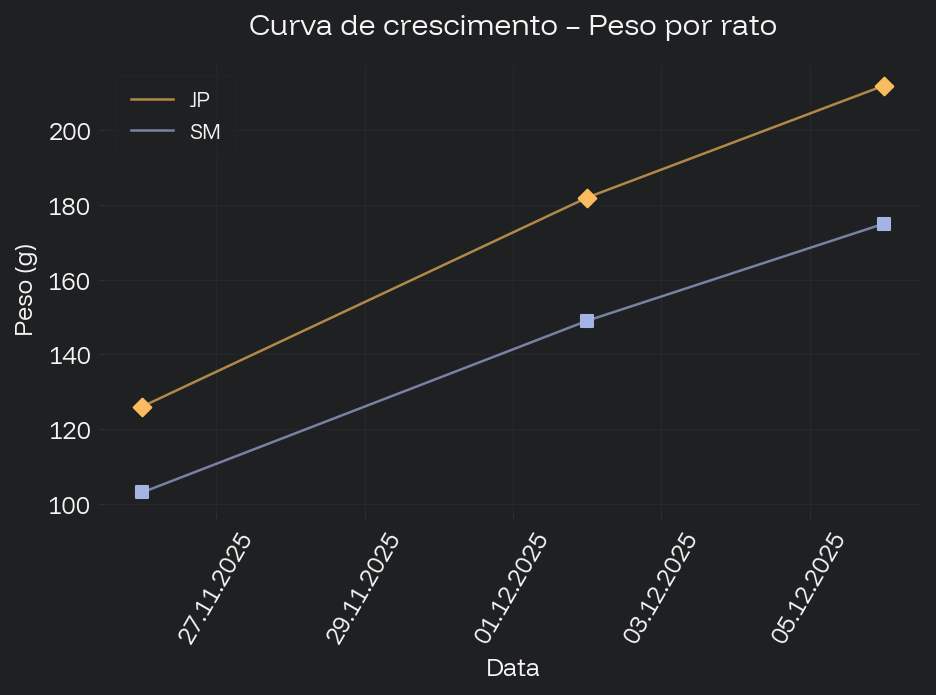

In [2050]:
def plot_crescimento_por_rato(df_bio: pd.DataFrame, salvar: bool = False):

    df = df_bio.copy()
    for col in ["Data", "Peso (± 1 g)", "ID"]:
        if col not in df.columns:
            raise ValueError(f"Coluna obrigatória ausente em Biometria: {col}")
    
    df = df.dropna(subset=["Data", "Peso (± 1 g)", "ID"])
    df = df.sort_values(["ID", "Data"])
    
    plt.figure()
    for rato, sub in df.groupby("ID"):
        plt.scatter(sub["Data"], sub["Peso (± 1 g)"],
                 marker = "D" if rato == "JP" else "s",
                 alpha  = 1,
                 zorder = 3)
        plt.plot(sub["Data"], sub["Peso (± 1 g)"],
                 marker = "",
                 alpha  = .67,
                 zorder = 2,
                 label  = rato)
    
    plt.title("Curva de crescimento – Peso por rato")
    plt.ylabel("Peso (g)"); plt.xlabel("Data"); plt.xticks(rotation=60)
    plt.legend(); plt.tight_layout()
    
    if salvar:
        out = FIGS_DIR / "crescimento_peso_por_rato.png"
        plt.savefig(out, dpi=150)
        print(f"Figura salva em: {out}")
    
    plt.show()

plot_crescimento_por_rato(bio)

## Evolução do BCS (Body Condition Score)

Gráfico do BCS ao longo do tempo, por rato.


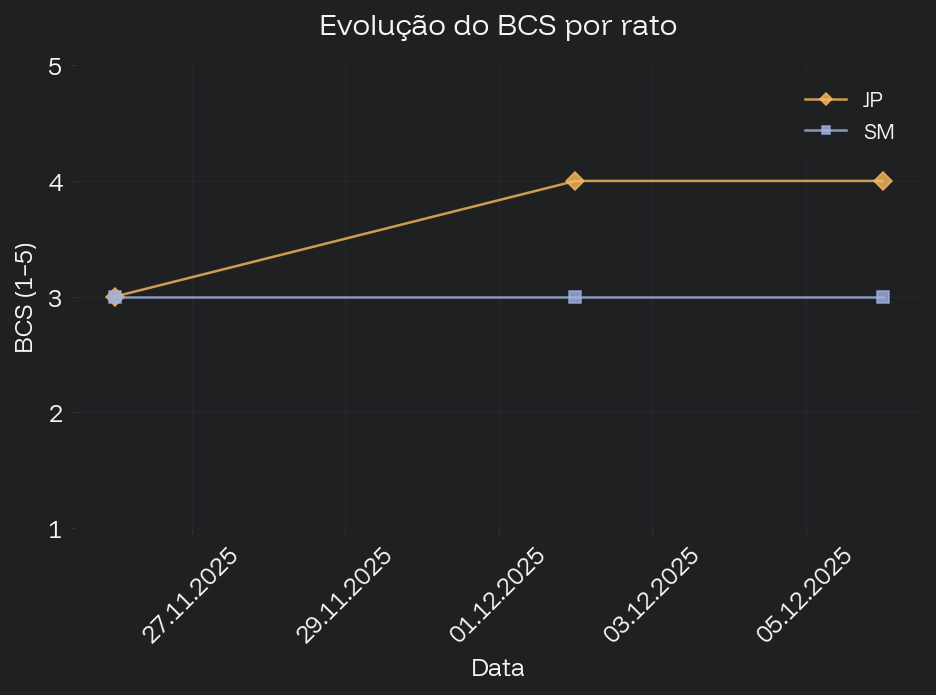

In [2051]:
def plot_bcs_por_rato(df_bio: pd.DataFrame, salvar: bool = False):
    df = df_bio.copy()
    for col in ["Data", "BCS (1–5)", "ID"]:
        if col not in df.columns:
            print("Colunas necessárias para BCS não encontradas. Pulando gráfico.")
            return
    
    df = df.dropna(subset=["Data", "BCS (1–5)", "ID"])
    df = df.sort_values(["ID", "Data"])
    
    plt.figure()
    for rato, sub in df.groupby("ID"):
        plt.plot(sub["Data"], sub["BCS (1–5)"],
                 marker="D" if rato == "JP" else "s",
                 alpha=0.8,
                 label=rato)
    
    plt.title("Evolução do BCS por rato")
    
    plt.ylabel("BCS (1–5)")
    plt.yticks([1, 2, 3, 4, 5])
    
    plt.xlabel("Data")
    plt.xticks(rotation=45)
    
    plt.legend()
    plt.tight_layout()
    
    if salvar:
        out = FIGS_DIR / "bcs_por_rato.png"
        plt.savefig(out, dpi=150)
        print(f"Figura salva em: {out}")
    
    plt.show()

plot_bcs_por_rato(bio)

## Consumo de ração – visão diária e por período

Aqui vamos:

1. Ver o consumo por registro (linha a linha)
2. Agregar por dia (total diário)
3. Agregar por dia e período (Manhã/Noite)


In [2052]:
def resumo_consumo(df_cons: pd.DataFrame):
    df = df_cons.copy()
    obrigatorias = ["Data", "Período", "Consumo (± 1 g)", "Consumo (± 2 mL)"]
    for col in obrigatorias:
        if col not in df.columns:
            raise ValueError(f"Coluna obrigatória ausente em Consumo: {col}")
    
    df = df.dropna(subset=["Data"])
    
    # Consumo por dia (soma de todos os períodos)
    diario = df.groupby("Data", as_index=False)[["Consumo (± 1 g)", "Consumo (± 2 mL)"]].sum()
    diario = diario.sort_values("Data")
    
    # Consumo por dia e período
    por_periodo = df.groupby(["Data", "Período"], as_index=False)[
        ["Consumo (± 1 g)", "Consumo (± 2 mL)"]
    ].sum().sort_values(["Data", "Período"])
    
    return diario, por_periodo

diario, por_periodo = resumo_consumo(cons)
diario, por_periodo

(         Data  Consumo (± 1 g)  Consumo (± 2 mL)
 0  2025-11-26               32                53
 1  2025-11-27               51                75
 2  2025-11-28               38                95
 3  2025-11-29               41                30
 4  2025-11-30               26                70
 5  2025-12-01               28                78
 6  2025-12-02               31                75
 7  2025-12-03               36                75
 8  2025-12-04               30                60
 9  2025-12-05               28                35
 10 2025-12-06               45                80
 11 2025-12-07               30                70
 12 2025-12-08               30                80,
          Data Período  Consumo (± 1 g)  Consumo (± 2 mL)
 0  2025-11-26     Dia               10                28
 1  2025-11-26   Noite               22                25
 2  2025-11-27     Dia               28                35
 3  2025-11-27   Noite               23                40
 4  2025-

### Gráfico – Consumo diário de ração

Soma de todos os períodos em cada dia.


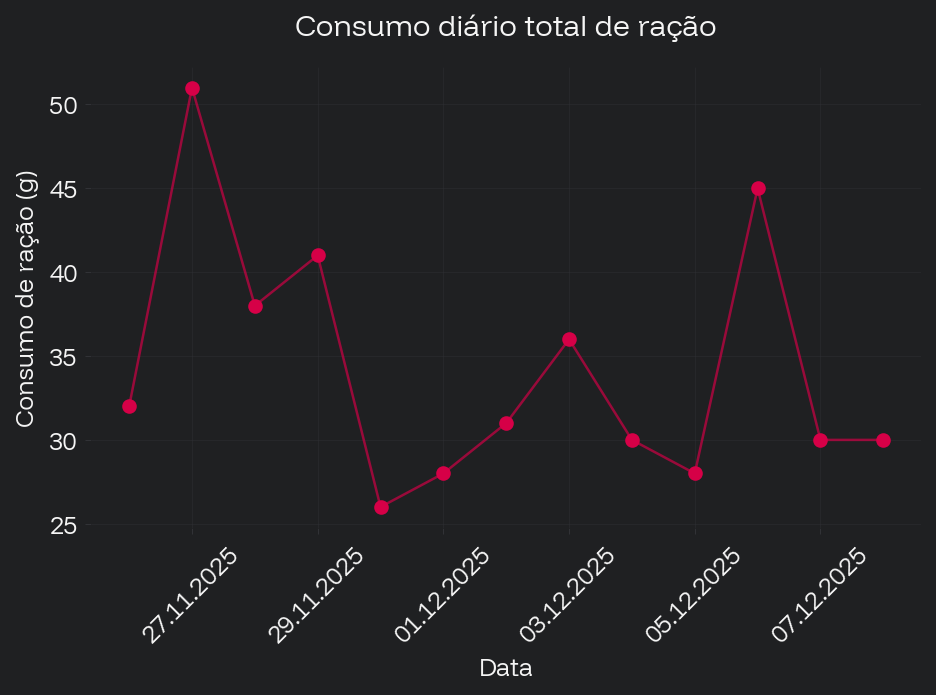

In [2053]:
def plot_consumo_diario(diario: pd.DataFrame, salvar: bool = False):
    df = diario.copy()
    if "Data" not in df.columns or "Consumo (± 1 g)" not in df.columns:
        print("Colunas necessárias não encontradas em 'diario'.")
        return
    
    df = df.dropna(subset=["Data", "Consumo (± 1 g)"])
    df = df.sort_values("Data")
    
    plt.figure()

    plt.title("Consumo diário total de ração")
    plt.ylabel("Consumo de ração (g)"); plt.xlabel("Data"); plt.xticks(rotation=45)
    
    plt.scatter(df["Data"], df["Consumo (± 1 g)"],
             color      = "#D60047",
             marker     = "o",
             alpha      = 1.0,      
             zorder     = 3)
    plt.plot(df["Data"], df["Consumo (± 1 g)"],
             color      = "#D60047",
             marker     = "",
             alpha      = .67,      
             zorder     = 3)

    plt.tight_layout()
    
    if salvar:
        out = FIGS_DIR / "consumo_racao_diario.png"
        plt.savefig(out, dpi=150)
        print(f"Figura salva em: {out}")
    
    plt.show()

plot_consumo_diario(diario)

### Gráfico – Consumo por período (Manhã vs Noite)

Podemos converter o `por_periodo` em formato wide (colunas: Manhã, Noite)
e fazer um gráfico comparativo.


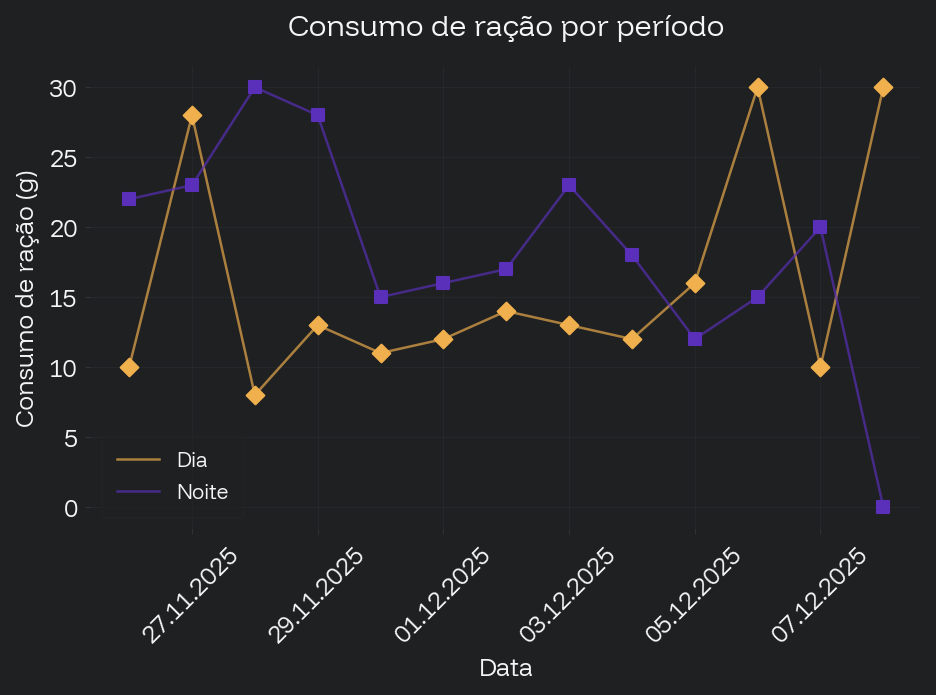

In [2054]:
def plot_consumo_por_periodo(por_periodo: pd.DataFrame, salvar: bool = False):
    df = por_periodo.copy()
    if not {"Data", "Período", "Consumo (± 1 g)"}.issubset(df.columns):
        print("Colunas necessárias não encontradas em 'por_periodo'.")
        return
    
    df_pivot = df.pivot(index="Data", columns="Período", values="Consumo (± 1 g)")
    df_pivot = df_pivot.sort_index()
    
    plt.figure()
    for col in df_pivot.columns:
        plt.scatter(df_pivot.index, df_pivot[col],
                 color  = "#F1B04E" if col == "Dia" else "#5A30BB",
                 marker = "D" if col == "Dia" else "s",
                 alpha  = 1.0,
                 zorder = 3)
        plt.plot(df_pivot.index, df_pivot[col],
                 color  = "#F1B04E" if col == "Dia" else "#5A30BB",
                 marker = "",
                 alpha  = .67,
                 label  = col,
                 zorder = 2)
    
    plt.title("Consumo de ração por período")
    plt.ylabel("Consumo de ração (g)"); plt.xlabel("Data"); plt.xticks(rotation=45)
    
    plt.legend(); plt.tight_layout()
    
    if salvar:
        out = FIGS_DIR / "consumo_racao_por_periodo.png"
        plt.savefig(out, dpi=150)
        print(f"Figura salva em: {out}")
    
    plt.show()

plot_consumo_por_periodo(por_periodo)

## Consumo de água – visão diária e por período

Aqui fazemos a mesma análise, mas focada em **Consumo (± 2 mL)**:

1. Consumo total diário de água.
2. Consumo por dia e por período (Manhã/Noite).

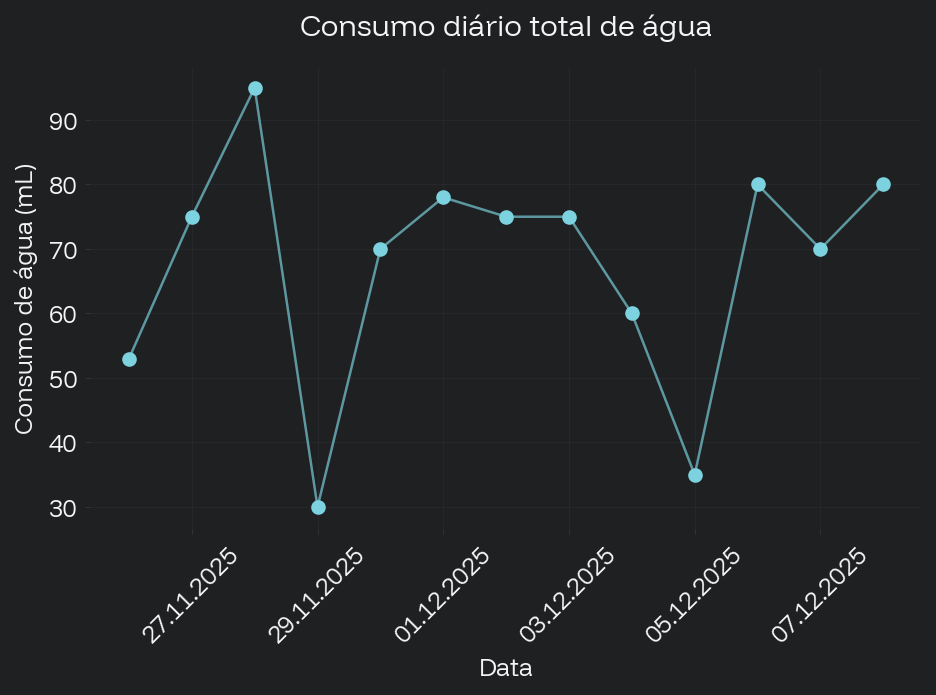

In [2055]:
def plot_consumo_agua_diario(diario: pd.DataFrame, salvar: bool = False):
    df = diario.copy()
    if "Data" not in df.columns or "Consumo (± 2 mL)" not in df.columns:
        print("Colunas necessárias não encontradas em 'diario'.")
        return
    
    df = df.dropna(subset=["Data", "Consumo (± 2 mL)"])
    df = df.sort_values("Data")
    
    plt.figure()
    
    plt.scatter(df["Data"], df["Consumo (± 2 mL)"],
                color  = "#7CD3DF",
                alpha  = 1.0,
                marker = "o",
                zorder = 3)
    
    plt.plot(df["Data"], df["Consumo (± 2 mL)"],
             color  = "#7CD3DF",
             alpha  = 0.67,
             zorder = 2)
    
    plt.title("Consumo diário total de água")
    plt.xlabel("Data"); plt.ylabel("Consumo de água (mL)"); plt.xticks(rotation=45)
    plt.tight_layout()
    
    if salvar:
        out = FIGS_DIR / "consumo_agua_diario.png"
        plt.savefig(out, dpi=150)
        print(f"Figura salva em: {out}")
    
    plt.show()

plot_consumo_agua_diario(diario)

### Gráfico – Consumo de água por período (Manhã vs Noite)

Usamos a mesma agregação `por_periodo`, mas focando na coluna
**Consumo (± 2 mL)**, para comparar consumo de água em diferentes períodos.


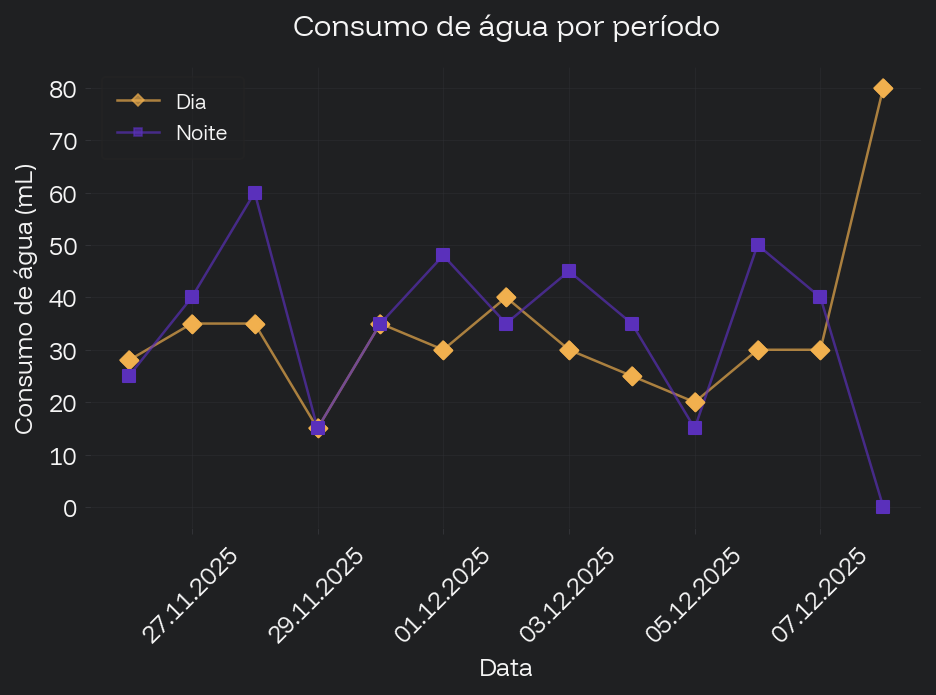

In [2056]:
def plot_consumo_agua_por_periodo(por_periodo: pd.DataFrame, salvar: bool = False):
    df = por_periodo.copy()
    if not {"Data", "Período", "Consumo (± 2 mL)"}.issubset(df.columns):
        print("Colunas necessárias não encontradas em 'por_periodo'.")
        return
    
    df_pivot = df.pivot(index="Data", columns="Período", values="Consumo (± 2 mL)")
    df_pivot = df_pivot.sort_index()
    
    plt.figure()
    for col in df_pivot.columns:
        plt.scatter(df_pivot.index, df_pivot[col],
                 color  = "#F1B04E" if col == "Dia" else "#5A30BB",
                 marker = "D" if col == "Dia" else "s",
                 alpha  = 1, 
                 zorder =  3)
        plt.plot(df_pivot.index, df_pivot[col],
                 color  = "#F1B04E" if col == "Dia" else "#5A30BB",
                 marker = "D" if col == "Dia" else "s",
                 alpha  = 0.67, 
                 label  = col,
                 zorder = 2)
    
    
    plt.title("Consumo de água por período")
    
    plt.ylabel("Consumo de água (mL)"); plt.xlabel("Data"); plt.xticks(rotation=45)
    plt.legend(); plt.tight_layout()
    
    if salvar:
        out = FIGS_DIR / "consumo_agua_por_periodo.png"
        plt.savefig(out, dpi=150)
        print(f"Figura salva em: {out}")
    
    plt.show()

plot_consumo_agua_por_periodo(por_periodo)

## Resumos estatísticos rápidos

Aqui olhamos:
- média de peso por rato
- BCS médio por rato
- consumo médio diário de ração e água


In [2057]:
print("=== Peso médio (g) por rato ===")
if "ID" in bio.columns and "Peso (± 1 g)" in bio.columns:
    print(bio.groupby("ID")["Peso (± 1 g)"].mean())
else:
    print("Colunas 'ID' ou 'Peso (± 1 g)' ausentes em Biometria.")

print("\n=== BCS médio por rato ===")
if "ID" in bio.columns and "BCS (1–5)" in bio.columns:
    print(bio.groupby("ID")["BCS (1–5)"].mean())
else:
    print("Colunas 'ID' ou 'BCS (1–5)' ausentes em Biometria.")

print("\n=== Consumo médio diário de ração (g) ===")
if "Consumo (± 1 g)" in diario.columns:
    print(f"{diario["Consumo (± 1 g)"].mean():.1f}")
else:
    print("Coluna 'Consumo (± 1 g)' ausente em 'diario'.")

print("\n=== Consumo médio diário de água (mL) ===")
if "Consumo (± 2 mL)" in diario.columns:
    print(f"{diario["Consumo (± 2 mL)"].mean():.1f}")
else:
    print("Coluna 'Consumo (± 2 mL)' ausente em 'diario'.")

=== Peso médio (g) por rato ===
ID
JP    173.333333
SM    142.333333
Name: Peso (± 1 g), dtype: float64

=== BCS médio por rato ===
ID
JP    3.666667
SM    3.000000
Name: BCS (1–5), dtype: float64

=== Consumo médio diário de ração (g) ===
34.3

=== Consumo médio diário de água (mL) ===
67.4


## Próximos passos possíveis

- Adicionar correlações (`peso` × `consumo`, `temperatura` × `consumo` caso registre depois).
- Criar análises de janela móvel (média dos últimos 7 dias).
- Exportar tabelas-resumo para `data/processed/`.
- Criar gráficos mais elaborados com seaborn (se quiser dar um passo além).